# Project 1: Trump, Twitter, and Text

In this project, we will work with the Twitter API in order to analyze Donald Trump's tweets.

**The project is due 11:59pm Sunday, October 20**

If you find yourself getting frustrated or stuck on one problem for too long, we suggest coming into office hours and working with friends in the class.

In [1]:
# Run this cell to set up your notebook
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import json
import time
import datetime

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

## Getting the data

The starting point and a key aspect of any data science project is getting the data. To get Twitter data, Twitter conveniently provides a developer API using which we can scrape data. More on that will follow in the coming discussions!

For now, we've made life easier for you by providing the data.

Start by running the following cells, which will download and then load Donald Trump's most recent tweets.

In [2]:
# Download the dataset
from utils import fetch_and_cache
data_url = 'https://cims.nyu.edu/~policast/recent_tweets.json'
file_name = 'realdonaldtrump_recent_tweets.json'

dest_path = fetch_and_cache(data_url=data_url, file=file_name)
print(f'Located at {dest_path}')

Using version already downloaded: Mon Oct  7 20:53:51 2019
MD5 hash of file: 216176fb098cd5d6b40b373b98bd3e6d
Located at data/realdonaldtrump_recent_tweets.json


In [3]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets were be saved.

    Returns:
        list: A list of Dictionary objects, each representing one tweet."""
    
    with open(path, "rb") as f:
        import json
        return json.load(f)

In [4]:
trump_tweets = load_tweets(dest_path)

If everything is working correctly correctly this should load roughly the last 3000 tweets by `realdonaldtrump`.

In [5]:
assert 2000 <= len(trump_tweets) <= 4000

If the assert statement above works, then continue on to question 2b.

### Question 1

We are limited to how many tweets we can download.  In what month is the oldest tweet from Trump?

In [6]:
# Enter the number of the month of the oldest tweet (e.g. 1 for January)
### BEGIN SOLUTION
tweets = trump_tweets[len(trump_tweets)-1]
date = time.strptime(tweets['created_at'],"%a %b %d %X %z %Y")
oldest_month = date[1] #TODO
### END SOLUTION

In [7]:
### BEGIN HIDDEN TESTS
assert oldest_month > 9
assert oldest_month < 12
### END HIDDEN TESTS


**IMPORTANT! PLEASE READ**

What if we want to access Donald Trump's old tweets? <br>
Unfortunately, you cannot download old tweets using the public Twitter APIs.  Fortunately, we have a snapshot of earlier tweets of Donald Trump that we can combine with the newer data that you downloaded   

We will again use the `fetch_and_cache` utility to download the dataset. 

In [8]:
# Download the dataset
from utils import fetch_and_cache
data_url = 'https://cims.nyu.edu/~policast/old_trump_tweets.json.zip'
file_name = 'old_trump_tweets.json.zip'

dest_path = fetch_and_cache(data_url=data_url, file=file_name)
print(f'Located at {dest_path}')

Using version already downloaded: Mon Oct  7 20:53:51 2019
MD5 hash of file: b6e33874de91d1a40207cdf9f9b51a09
Located at data/old_trump_tweets.json.zip


Finally, we we will load the tweets directly from the compressed file without decompressing it first.

In [9]:
my_zip = zipfile.ZipFile(dest_path, 'r')
with my_zip.open("old_trump_tweets.json", "r") as f:
    old_trump_tweets = json.load(f)

This data is formatted identically to the recent tweets we just downloaded:

In [10]:
pprint(old_trump_tweets[0])

Pretty printing has been turned OFF


As a dictionary we can also list the keys:

In [11]:
old_trump_tweets[0].keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

Since we're giving you a zipfile of old tweets, you may wonder why we didn't just give you a zipfile of ALL tweets and save you the trouble of creating a Twitter developer account. The reason is that we wanted you to see what it's like to collect data from the real world on your own. It can be a pain!

And for those of you that never got your developer accounts, you can see it can be even more of a pain that we expected. Sorry to anybody that wasted a bunch of time trying to get things working.

### Question 2

Merge the `old_trump_tweets` and the `trump_tweets` we downloaded from twitter into one giant list of tweets. 

**Important:** There may be some overlap so be sure to eliminate duplicate tweets.  
**Hint:** the `id` of a tweet is always unique.

In [12]:
### BEGIN SOLUTION
oldtweets = set()
for tweet in old_trump_tweets:
    oldtweets.add(tweet['id'])

trumptweets = set()
for tweet in trump_tweets:
    trumptweets.add(tweet['id'])
uniquetweets = oldtweets - trumptweets

filteredtweets = []
for tweet in old_trump_tweets:
    if tweet['id'] in uniquetweets:
        filteredtweets = filteredtweets + [tweet]

all_tweets = filteredtweets + trump_tweets #TODO
### END SOLUTION

In [13]:
assert len(all_tweets) > len(trump_tweets)
assert len(all_tweets) > len(old_trump_tweets)
### BEGIN HIDDEN TESTS
assert len(set([t['id'] for t in all_tweets])) == len([t['id'] for t in all_tweets])
### END HIDDEN TESTS

### Question 3

Construct a DataFrame called `trump` containing all the tweets stored in `all_tweets`. The index of the dataframe should be the ID of each tweet (looks something like `907698529606541312`). It should have these columns:

- `time`: The time the tweet was created encoded as a datetime object. (Use `pd.to_datetime` to encode the timestamp.)
- `source`: The source device of the tweet.
- `text`: The text of the tweet.
- `retweet_count`: The retweet count of the tweet. 

Finally, **the resulting dataframe should be sorted by the index.**

**Warning:** *Some tweets will store the text in the `text` field and other will use the `full_text` field.*

In [14]:
### BEGIN SOLUTION
for tweets in all_tweets:
    if 'full_text' in tweets.keys():
        tweets['text'] = tweets.pop('full_text')

trump = pd.DataFrame(all_tweets).set_index(['id']).sort_index()#TODO
trump['created_at'] = pd.to_datetime(trump['created_at'])
trump = trump[['created_at', 'source', 'text', 'retweet_count']].rename(columns = {'created_at': 'time'})
trump.head()
### END SOLUTION

,time,source,text,retweet_count
id,,,,
690171032150237184,2016-01-21 13:56:11+00:00,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059
690171403388104704,2016-01-21 13:57:39+00:00,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339
690173226341691392,2016-01-21 14:04:54+00:00,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006
690176882055114758,2016-01-21 14:19:26+00:00,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266
690180284189310976,2016-01-21 14:32:57+00:00,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886


In [15]:
assert isinstance(trump, pd.DataFrame)
assert trump.shape[0] < 11000
assert trump.shape[1] >= 4
assert 831846101179314177 in trump.index
assert 753063644578144260 in trump.index
assert all(col in trump.columns for col in ['time', 'source', 'text', 'retweet_count'])
# If you fail these tests, you probably tried to use __dict__ or _json to read in the tweets
assert np.sometrue([('Twitter for iPhone' in s) for s in trump['source'].unique()])
assert isinstance(trump['time'].dtype, pd.core.dtypes.dtypes.DatetimeTZDtype)
assert trump['text'].dtype == np.dtype('O')
assert trump['retweet_count'].dtype == np.dtype('int64')

## Question 4: Tweet Source Analysis

In the following questions, we are going to find out the charateristics of Trump tweets and the devices used for the tweets.

First let's examine the source field:

In [16]:
trump['source'].unique()

array(['<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>',
       '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       '<a href="https://periscope.tv" rel="nofollow">Periscope</a>',
       '<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>'],
      dtype=object)

## Question 4a

Remove the HTML tags from the source field. 

**Hint:** Use `trump['source'].str.replace` and your favorite regular expression.

In [17]:
### BEGIN SOLUTION
trump['source'] = trump['source'].str.replace('<(/)?a.*?>', '')#TODO
trump.head()
### END SOLUTION

,time,source,text,retweet_count
id,,,,
690171032150237184,2016-01-21 13:56:11+00:00,Twitter for Android,"""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059
690171403388104704,2016-01-21 13:57:39+00:00,Twitter for Android,"""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339
690173226341691392,2016-01-21 14:04:54+00:00,Twitter for Android,So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006
690176882055114758,2016-01-21 14:19:26+00:00,Twitter for Android,"Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266
690180284189310976,2016-01-21 14:32:57+00:00,Twitter for Android,Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886


In [18]:
from datetime import datetime, timezone
ELEC_DATE = datetime(2016, 11, 8, tzinfo=timezone.utc)
INAUG_DATE = datetime(2017, 1, 20, tzinfo=timezone.utc)
assert set(trump[(trump['time'] > ELEC_DATE) & (trump['time'] < INAUG_DATE) ]['source'].unique()) == set(['Twitter Ads',
 'Twitter Web Client',
 'Twitter for Android',
 'Twitter for iPhone'])

We can see in the following plot that there are two device types that are more commonly used

Text(0, 0.5, 'Number of Tweets')

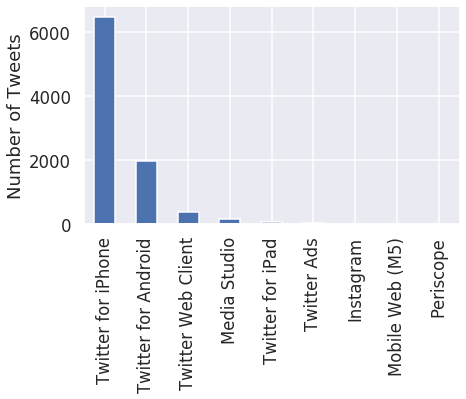

In [19]:
trump['source'].value_counts().plot(kind="bar")
plt.ylabel("Number of Tweets")

## Question 4b


Is there a difference between his Tweet behavior across these devices? We will attempt to answer this question in our subsequent analysis.

First, we'll take a look at whether Trump's tweets from an Android come at different times than his tweets from an iPhone. Note that Twitter gives us his tweets in the [UTC timezone](https://www.wikiwand.com/en/List_of_UTC_time_offsets) (notice the `+0000` in the first few tweets)

In [20]:
for t in trump_tweets[0:3]:
    print(t['created_at'])

Tue Oct 16 16:22:11 +0000 2018
Tue Oct 16 16:18:08 +0000 2018
Tue Oct 16 15:26:33 +0000 2018


We'll convert the tweet times to US Eastern Time, the timezone of New York and Washington D.C., since those are the places we would expect the most tweet activity from Trump.

In [21]:
trump['est_time'] = (
    trump['time'].dt.tz_convert("EST") # Convert to Eastern Time
    # If your data frame is, for some reason, not timezone-aware
    # you might need the below two lines instead:
    #  trump['time'].dt.tz_localize("UTC") # Set initial timezone to UTC
    # .trump['time'].dt.tz_convert("EST") # Convert to Eastern Time
)
trump.head()

,time,source,text,retweet_count,est_time
id,,,,,
690171032150237184,2016-01-21 13:56:11+00:00,Twitter for Android,"""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059,2016-01-21 08:56:11-05:00
690171403388104704,2016-01-21 13:57:39+00:00,Twitter for Android,"""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339,2016-01-21 08:57:39-05:00
690173226341691392,2016-01-21 14:04:54+00:00,Twitter for Android,So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006,2016-01-21 09:04:54-05:00
690176882055114758,2016-01-21 14:19:26+00:00,Twitter for Android,"Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266,2016-01-21 09:19:26-05:00
690180284189310976,2016-01-21 14:32:57+00:00,Twitter for Android,Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886,2016-01-21 09:32:57-05:00


**What you need to do:**

Add a column called `hour` to the `trump` table which contains the hour of the day as floating point number computed by:

$$
\text{hour} + \frac{\text{minute}}{60} + \frac{\text{second}}{60^2}
$$


In [22]:
### BEGIN SOLUTION
time = [re.findall('(\d+)-(\d+)-(\d+) (\d+):(\d+):(\d+)', str(row)) for row in trump['est_time']]
hour = [(float(row[0][3]) + (float(row[0][4])/60) + (float(row[0][5])/(60**2))) for row in time] 

trump['hour'] = hour #TODO
### END SOLUTION

In [23]:
assert np.isclose(trump.loc[690171032150237184]['hour'], 8.93639)

## Question 4c

Use this data along with the seaborn `distplot` function to examine the distribution over hours of the day in eastern time that trump tweets on each device for the 2 most commonly used devices.  Your plot should look similar to the following. 

<img src="images/device_hour2.png" width="600px" />

Text(0, 0.5, 'fraction')

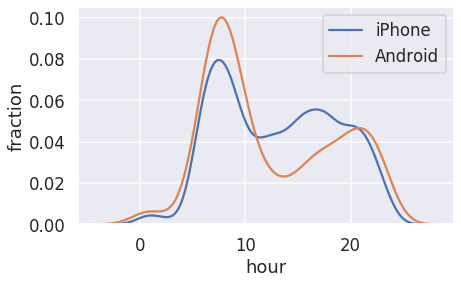

In [24]:
### make your plot here
### BEGIN SOLUTION
#TODO
values = trump[['hour', 'source']].set_index('source').loc[['Twitter for iPhone', 'Twitter for Android']]
iphone = values.loc[values.index == 'Twitter for iPhone']
android = values.loc[values.index == 'Twitter for Android']
sns.distplot(iphone['hour'], hist = False, label = 'iPhone')
sns.distplot(android['hour'], hist = False, label = 'Android')
plt.ylabel('fraction')
### END SOLUTION


## Question 4d

According to [this Verge article](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android), Donald Trump switched from an Android to an iPhone sometime in March 2017.

Create a figure identical to your figure from 4c, except that you should show the results only from 2016. If you get stuck consider looking at the `year_fraction` function from the next problem.

During the campaign, it was theorized that Donald Trump's tweets from Android were written by him personally, and the tweets from iPhone were from his staff. Does your figure give support to this theory?

Text(0, 0.5, 'fraction')

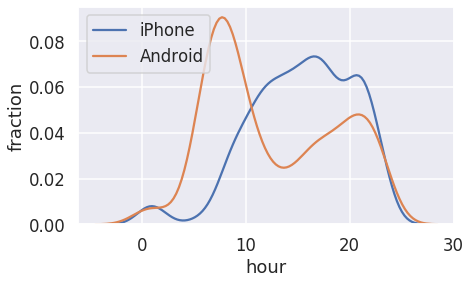

In [25]:
### make your plot here
### BEGIN SOLUTION
#TODO

trump2016 = trump[trump['time'].dt.year == 2016]
values = trump2016[['hour', 'source']].set_index('source').loc[['Twitter for iPhone', 'Twitter for Android']]
iphone = values.loc[values.index == 'Twitter for iPhone']
android = values.loc[values.index == 'Twitter for Android']
sns.distplot(iphone['hour'], hist = False, label = 'iPhone')
sns.distplot(android['hour'], hist = False, label = 'Android')
plt.ylabel('fraction')
### END SOLUTION

Yes, our figure shows that the Android tweets were typically very late at night when Donald Trump is known to tweet, and when paid staff are unlikely to be posting.

## Question 5

Let's now look at which device he has used over the entire time period of this dataset.

To examine the distribution of dates we will convert the date to a fractional year that can be plotted as a distribution.

(Code borrowed from https://stackoverflow.com/questions/6451655/python-how-to-convert-datetime-dates-to-decimal-years)

In [26]:
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length


trump['year'] = trump['time'].apply(year_fraction)

Use the `sns.distplot` to overlay the distributions of the 2 most frequently used web technologies over the years.  Your final plot should look like:

<img src="images/source_years.png" width="600px" />


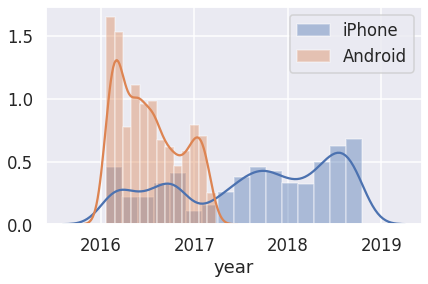

In [27]:
### BEGIN SOLUTION
#TODO
trumpyear = trump[['source', 'year']].set_index('source')
iphoneyear = trumpyear.loc[trumpyear.index == 'Twitter for iPhone']
androidyear = trumpyear.loc[trumpyear.index == 'Twitter for Android']
sns.distplot(iphoneyear['year'], label = 'iPhone')
sns.distplot(androidyear['year'], label = 'Android')
plt.legend()
### END SOLUTION

## Question 6: Sentiment Analysis

It turns out that we can use the words in Trump's tweets to calculate a measure of the sentiment of the tweet. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Trump's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [28]:
print(''.join(open("vader_lexicon.txt").readlines()[-100:]))

withdrawal	0.1	1.57797	[1, -1, 0, -2, -2, 2, -1, 1, 0, 3]
woe	-1.8	0.6	[-3, -2, -2, -2, -1, -1, -2, -1, -2, -2]
woebegone	-2.6	0.66332	[-3, -2, -3, -2, -2, -4, -3, -2, -2, -3]
woebegoneness	-1.1	1.37477	[-3, 0, -1, 1, -1, -4, 0, -1, -1, -1]
woeful	-1.9	0.83066	[-1, -2, -2, -1, -3, -3, -1, -2, -1, -3]
woefully	-1.7	1.48661	[-1, -3, -2, 1, -3, -3, -2, -2, 1, -3]
woefulness	-2.1	0.7	[-3, -2, -2, -1, -2, -3, -3, -1, -2, -2]
woes	-1.9	0.83066	[-2, -2, -2, -1, -2, -3, -3, 0, -2, -2]
woesome	-1.2	1.6	[-2, -3, -2, -1, 0, 3, -2, -2, -1, -2]
won	2.7	0.9	[3, 4, 2, 2, 2, 4, 4, 2, 2, 2]
wonderful	2.7	0.78102	[2, 3, 3, 2, 4, 2, 2, 3, 4, 2]
wonderfully	2.9	0.83066	[1, 3, 3, 4, 3, 2, 3, 3, 4, 3]
wonderfulness	2.9	0.53852	[3, 2, 3, 3, 3, 3, 3, 2, 4, 3]
woo	2.1	1.37477	[4, 2, 1, 3, 2, 2, -1, 2, 2, 4]
woohoo	2.3	1.1	[3, 3, 1, 4, 4, 2, 1, 1, 2, 2]
woot	1.8	1.07703	[2, 0, 2, 2, 2, 2, 0, 4, 2, 2]
worn	-1.2	0.4	[-1, -1, -1, -1, -1, -1, -2, -1, -2, -1]
worried	-1.2	0.74833	[-1, -1, -1, -1, -1, -2, -3, 0, -1, 

## Question 6a

As you can see, the lexicon contains emojis too! The first column of the lexicon is the *token*, or the word itself. The second column is the *polarity* of the word, or how positive / negative it is.

(How did they decide the polarities of these words? What are the other two columns in the lexicon? See the link above.)

 Read in the lexicon into a DataFrame called `sent`. The index of the DF should be the tokens in the lexicon. `sent` should have one column: `polarity`: The polarity of each token.

In [31]:
### BEGIN SOLUTION
with open('vader_lexicon.txt') as f:
    log = f.readlines()
line = log[0]
x = [line.split('\t') for line in log]
sent = pd.DataFrame(x).rename(columns={0: 'tokens', 1: 'polarity'}).set_index('tokens')[['polarity']]
sent['polarity'] = pd.to_numeric(sent['polarity'])
### END SOLUTION

In [32]:
assert isinstance(sent, pd.DataFrame)
assert sent.shape == (7517, 1)
assert list(sent.index[5000:5005]) == ['paranoids', 'pardon', 'pardoned', 'pardoning', 'pardons']
assert np.allclose(sent['polarity'].head(), [-1.5, -0.4, -1.5, -0.4, -0.7])

## Question 6b

Now, let's use this lexicon to calculate the overall sentiment for each of Trump's tweets. Here's the basic idea:

1. For each tweet, find the sentiment of each word.
2. Calculate the sentiment of each tweet by taking the sum of the sentiments of its words.

First, let's lowercase the text in the tweets since the lexicon is also lowercase. Set the `text` column of the `trump` DF to be the lowercased text of each tweet.

In [33]:
### BEGIN SOLUTION
#TODO
trump['text'] = [text.lower() for text in trump['text']]
### END SOLUTION

In [34]:
assert trump['text'].loc[884740553040175104] == 'working hard to get the olympics for the united states (l.a.). stay tuned!'

## Question 6c

Now, let's get rid of punctuation since it'll cause us to fail to match words. Create a new column called `no_punc` in the `trump` DF to be the lowercased text of each tweet with all punctuation replaced by a single space. We consider punctuation characters to be any character that isn't a Unicode word character or a whitespace character. You may want to consult the Python documentation on regexes for this problem.

(Why don't we simply remove punctuation instead of replacing with a space? See if you can figure this out by looking at the tweet data.)

In [35]:
# Save your regex in punct_re

### BEGIN SOLUTION
#TODO
punct_re = r'[^(\s\w)]'
trump['no_punc'] = trump['text'].str.replace(punct_re, ' ')
### END SOLUTION

In [36]:
assert isinstance(punct_re, str)
assert re.search(punct_re, 'this') is None
assert re.search(punct_re, 'this is ok') is None
assert re.search(punct_re, 'this is\nok') is None
assert re.search(punct_re, 'this is not ok.') is not None
assert re.search(punct_re, 'this#is#ok') is not None
assert re.search(punct_re, 'this^is ok') is not None
assert trump['no_punc'].loc[800329364986626048] == 'i watched parts of  nbcsnl saturday night live last night  it is a totally one sided  biased show   nothing funny at all  equal time for us '
assert trump['no_punc'].loc[894620077634592769] == 'on  purpleheartday i thank all the brave men and women who have sacrificed in battle for this great nation   usa   https   t co qmfdlslp6p'
# If you fail these tests, you accidentally changed the text column
assert trump['text'].loc[884740553040175104] == 'working hard to get the olympics for the united states (l.a.). stay tuned!'

## Question 6d:


Now, let's convert the tweets into what's called a [*tidy format*](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) to make the sentiments easier to calculate. Use the `no_punc` column of `trump` to create a table called `tidy_format`. The index of the table should be the IDs of the tweets, repeated once for every word in the tweet. It has two columns:

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.

The first few rows of our `tidy_format` table look like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>num</th>
      <th>word</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>894661651760377856</th>
      <td>0</td>
      <td>i</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>1</td>
      <td>think</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>2</td>
      <td>senator</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>3</td>
      <td>blumenthal</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>4</td>
      <td>should</td>
    </tr>
  </tbody>
</table>

**Note that you'll get different results depending on when you pulled in the tweets.** However, you can double check that your tweet with ID `894661651760377856` has the same rows as ours. Our tests don't check whether your table looks exactly like ours.

As usual, try to avoid using any for loops. Our solution uses a chain of 5 methods on the 'trump' DF, albeit using some rather advanced Pandas hacking.

* **Hint 1:** Try looking at the `expand` argument to pandas' `str.split`.

* **Hint 2:** Try looking at the `stack()` method.

* **Hint 3:** Try looking at the `level` parameter of the `reset_index` method.


In [37]:
### BEGIN SOLUTION
temp = trump['no_punc']
space = temp.str.replace('\s+', ' ')
nospace = pd.DataFrame(space.str.split(expand=True).stack())
nospace.reset_index(inplace=True)
tidy_format = nospace.set_index('id').rename(columns={'level_1': 'num', 0: 'word'})#TODO
### END SOLUTION

In [38]:
assert tidy_format.loc[894661651760377856].shape == (27, 2)
assert ' '.join(list(tidy_format.loc[894661651760377856]['word'])) == 'i think senator blumenthal should take a nice long vacation in vietnam where he lied about his service so he can at least say he was there'

## Question 6e:

Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each tweet: we can join the table with the lexicon table. 

Add a `polarity` column to the `trump` table.  The `polarity` column should contain the sum of the sentiment polarity of each word in the text of the tweet.

**Hint** you will need to merge the `tidy_format` and `sent` tables and group the final answer.


In [39]:
### BEGIN SOLUTION
polarity_sum = (tidy_format.merge(sent, how = "inner",left_on = "word", right_index = True).groupby('id').sum())
trump['polarity'] = polarity_sum[['polarity']]
trump = trump.fillna(value=0)
### END SOLUTION

In [40]:
assert np.allclose(trump.loc[744701872456536064, 'polarity'], 8.4)
assert np.allclose(trump.loc[745304731346702336, 'polarity'], 2.5)
assert np.allclose(trump.loc[744519497764184064, 'polarity'], 1.7)
assert np.allclose(trump.loc[894661651760377856, 'polarity'], 0.2)
assert np.allclose(trump.loc[894620077634592769, 'polarity'], 5.4)
# If you fail this test, you dropped tweets with 0 polarity
assert np.allclose(trump.loc[744355251365511169, 'polarity'], 0.0)

Now we have a measure of the sentiment of each of his tweets! Note that this calculation is rather basic; you can read over the VADER readme to understand a more robust sentiment analysis.

Now, run the cells below to see the most positive and most negative tweets from Trump in your dataset:

In [41]:
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   it is outrageous that poisonous synthetic heroin fentanyl comes pouring into the u.s. postal system from china. we can, and must, end this now! the senate should pass the stop act – and firmly stop this poison from killing our children and destroying our country. no more delay!

   the rigged russian witch hunt goes on and on as the “originators and founders” of this scam continue to be fired and demoted for their corrupt and illegal activity. all credibility is gone from this terrible hoax, and much more will be lost as it proceeds. no collusion!

   james comey is a proven leaker &amp; liar. virtually everyone in washington thought he should be fired for the terrible job he did-until he was, in fact, fired. he leaked classified information, for which he should be prosecuted. he lied to congress under oath. he is a weak and.....

   there is no collusion! the robert mueller rigged witch hunt, headed now by 17 (increased from 13, including an obama white house

In [42]:
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   congratulations to patrick reed on his great and courageous masters win! when patrick had his amazing win at doral 5 years ago, people saw his great talent, and a bright future ahead. now he is the masters champion!

   my supporters are the smartest, strongest, most hard working and most loyal that we have seen in our countries history. it is a beautiful thing to watch as we win elections and gather support from all over the country. as we get stronger, so does our country. best numbers ever!

   thank you to all of my great supporters, really big progress being made. other countries wanting to fix crazy trade deals. economy is roaring. supreme court pick getting great reviews. new poll says trump, at over 90%, is the most popular republican in history of the party. wow!

   thank you, @wvgovernor jim justice, for that warm introduction. tonight, it was my great honor to attend the “greenbrier classic – salute to service dinner” in west virginia! god bless ou

## Question 6g

Plot the distribution of tweet sentiments broken down by whether the text of the tweet contains `nyt` or `fox`.  Then in the box below comment on what we observe?

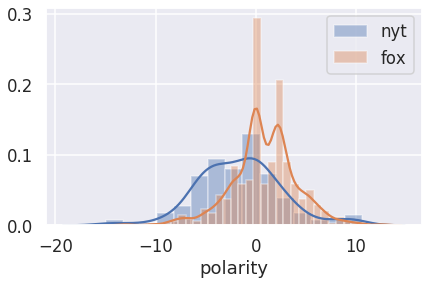

In [43]:
### BEGIN SOLUTION
#TODO
nyt = trump[trump['no_punc'].str.contains('nyt')]['polarity']
fox = trump[trump['no_punc'].str.contains('fox')]['polarity']
sns.distplot(nyt, label = 'nyt')
sns.distplot(fox, label = 'fox')
plt.legend()
### END SOLUTION

#### Comment on what you observe:

We notice that the president appears to say more positive things about Fox than the 
New York Times.  



In [44]:
tidy_format

,num,word
id,,
690171032150237184,0,bigop1
690171032150237184,1,realdonaldtrump
690171032150237184,2,sarahpalinusa
690171032150237184,3,https
690171032150237184,4,t
690171032150237184,5,co
690171032150237184,6,3kyqgqevyd
690171403388104704,0,americanaspie
690171403388104704,1,glennbeck


## Question 7: Engagement

## Question 7a

In this problem, we'll explore which words led to a greater average number of retweets. For example, at the time of this writing, Donald Trump has two tweets that contain the word 'oakland' (tweets 932570628451954688 and 1016609920031117312) with 36757 and 10286 retweets respectively, for an average of 23,521.5.

Find the top 20 most retweeted words. Include only words that appear in at least 25 tweets. As usual, try to do this without any for loops. You can string together ~7 pandas commands and get everything done on one line.

Your `top_20` table should have this format:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>retweet_count</th>
    </tr>
    <tr>
      <th>word</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>jong</th>
      <td>40675.666667</td>
    </tr>
    <tr>
      <th>try</th>
      <td>33937.800000</td>
    </tr>
    <tr>
      <th>kim</th>
      <td>32849.595745</td>
    </tr>
    <tr>
      <th>un</th>
      <td>32741.731707</td>
    </tr>
    <tr>
      <th>maybe</th>
      <td>30473.192308</td>
    </tr>
  </tbody>
</table>

Note that the contents of the table may be different based on how many tweets you pulled and when you did so; focus on the format, not the numbers.

In [45]:
### BEGIN SOLUTION
temp = tidy_format.merge(trump,how = 'inner',left_index = True, right_index = True)
count = temp[['word', 'retweet_count']].groupby('word').count()
atleast25 = count[count['retweet_count'] >= 25]
temp1 = temp.merge(atleast25,how='inner',left_on='word', right_index=True)
temp2 = temp1[['word','retweet_count_x']].groupby(['word']).sum()
final = temp2.merge(atleast25,how='inner',left_index=True, right_index=True)
final['average'] = final['retweet_count_x']/final['retweet_count']
top_20 = final.sort_values('average', ascending=False).iloc[0:21]#TODO
### END SOLUTION

In [46]:
# Although it can't be guaranteed, it's very likely that some of these words will be in the top 20
# Although this may vary depending on when exactly you pulled your data:
assert 'un'     in top_20.index
assert 'nuclear' in top_20.index
assert 'old'    in top_20.index
assert 'nfl'    in top_20.index

Here's a bar chart of your results:

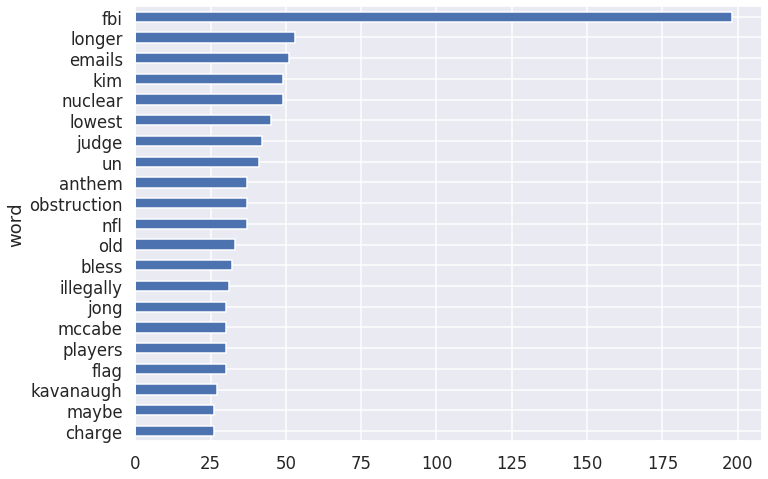

In [47]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8));

## Question 7b

At some point in time, "kim", "jong" and "un" were apparently really popular in Trump's tweets! It seems like we can conclude that his tweets involving jong are more popular than his other tweets. Or can we?

Consider each of the statements about possible confounding factors below. State whether each statement is true or false and explain. If the statement is true, state whether the confounding factor could have made kim jong un related tweets higher in the list than they should be.

1. We didn't restrict our word list to nouns, so we have unhelpful words like "let" and "any" in our result.
1. We didn't remove hashtags in our text, so we have duplicate words (eg. #great and great).
1. We didn't account for the fact that Trump's follower count has increased over time.


1. True. However, this will not cause "kim", "jong" and "un" to top the list of retweeted
words since restricting to nouns does not affect the count of the retweets containing "kim", "jong" and "un".
2. False. We removed hashtags in our text when we removed punctuation.
3. True. This could indeed cause "kim", "jong" and "un" to appear higher on the list than it should have.
If his follower count increased over time, we would expect the number of retweets over time
to increase as well, regardless of what words are in the tweets. If he just started using the
term "fake news" recently, it's likely that those tweets would get more retweets just because
he had more followers than before.



## Question 8

Using the `trump` tweets construct an interesting plot describing a property of the data and discuss what you found below.

**Ideas:**

1. How has the sentiment changed with length of the tweets?
1. Does sentiment affect retweet count?
1. Are retweets more negative than regular tweets?
1. Are there any spikes in the number of retweets and do the correspond to world events? 
1. *Bonus:* How many Russian twitter bots follow Trump? 
1. What terms have an especially positive or negative sentiment?

You can look at other data sources and even tweets.


### Plot:

Text(0, 0.5, 'Average Polarity')

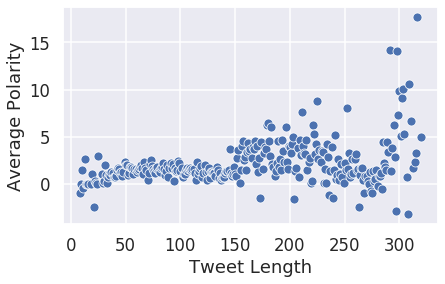

In [48]:
trump['tweet_length'] = [len(sent) for sent in trump['no_punc']]
average = trump[['polarity', 'tweet_length']].groupby('tweet_length').mean()
average['tweet_length'] = average.index
sns.scatterplot(x='tweet_length', y='polarity',data=average)
plt.xlabel('Tweet Length')
plt.ylabel('Average Polarity')

### Discussion of Your Plot:

I plotted how the sentiment changed with length of the tweets. As seen in the plot, the polarity of a tweet seems to go up as the length of the tweet increases with a few outliers. The tweets with the highest polarity, are in the range of the longest lengths. This might be because longer tweets have more content of a message trump might be trying to get across. Whether it is a long rant about defending his crimes, or speaking out against the media, his longer tweets are more opinionated.

## Submission

Congrats, you just finished Project 1!